# Analyse TripAdvisor Hotelbewertungen (DuckDB + NLP)

## Datenquelle via DuckDB
Dieses Notebook kann den Datensatz direkt aus DuckDB lesen (empfohlen bei größeren CSVs).

In [10]:
# 1) Projektpfade & sys.path konfigurieren
from pathlib import Path
import sys

cwd = Path.cwd()
# Wenn Notebook in ./notebooks liegt, ist der Projekt-Root der Parent
PROJECT_ROOT = cwd.parent if cwd.name.lower() == "notebooks" else (cwd if (cwd / "src").exists() else cwd.parent)

# src auffindbar machen
sys.path.insert(0, str(PROJECT_ROOT))

DB_PATH  = PROJECT_ROOT / "data" / "tripadvisor.duckdb"
CSV_PATH = PROJECT_ROOT / "data" / "tripadvisor_hotel_reviews.csv"
REPORTS  = PROJECT_ROOT / "reports"

(PROJECT_ROOT / "data").mkdir(exist_ok=True, parents=True)
REPORTS.mkdir(exist_ok=True, parents=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DB_PATH     :", DB_PATH)
print("CSV_PATH    :", CSV_PATH)
print("REPORTS     :", REPORTS)


PROJECT_ROOT: C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1
DB_PATH     : C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\data\tripadvisor.duckdb
CSV_PATH    : C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\data\tripadvisor_hotel_reviews.csv
REPORTS     : C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\reports


In [11]:
import platform, pandas as pd, numpy as np, sklearn as sk, gensim, nltk, duckdb, matplotlib
print("Python    :", platform.python_version())
print("pandas    :", pd.__version__)
print("numpy     :", np.__version__)
print("sklearn   :", sk.__version__)
print("gensim    :", gensim.__version__)
print("nltk      :", nltk.__version__)
print("duckdb    :", duckdb.__version__)
print("matplotlib:", matplotlib.__version__)


Python    : 3.11.2
pandas    : 2.3.2
numpy     : 1.26.4
sklearn   : 1.7.1
gensim    : 4.3.3
nltk      : 3.9.1
duckdb    : 1.3.2
matplotlib: 3.10.5


In [12]:
from src import data_store
from src.data_store import bootstrap_from_csv, query_df

# Standard-DB-Pfad im Modul auf die absolute Datei setzen
data_store.DEFAULT_DB = str(DB_PATH)

# DB/Tabelle erstellen, falls nötig
if not DB_PATH.exists():
    assert CSV_PATH.exists(), "❌ CSV fehlt: data/tripadvisor_hotel_reviews.csv"
    bootstrap_from_csv(str(CSV_PATH), db_path=str(DB_PATH), overwrite=True)
else:
    try:
        query_df("SELECT 1 FROM reviews LIMIT 1", db_path=str(DB_PATH))
    except Exception:
        # Tabelle fehlt -> aus CSV neu aufbauen
        bootstrap_from_csv(str(CSV_PATH), db_path=str(DB_PATH), overwrite=True)

# Vorschau aus DuckDB
query_df("SELECT * FROM reviews LIMIT 5", db_path=str(DB_PATH))


,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,"hotel stayed hotel monaco cruise, rooms genero...",5
2,boutique charmer great location wife recently ...,5
3,"loved inn husband wanted romantic away night, ...",5
4,pay location location perfect walking distance...,3


In [13]:
from src.data_store import get_text_and_rating
df_raw = get_text_and_rating(db_path=str(DB_PATH))
df_raw.head()


,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,"hotel stayed hotel monaco cruise, rooms genero...",5
2,boutique charmer great location wife recently ...,5
3,"loved inn husband wanted romantic away night, ...",5
4,pay location location perfect walking distance...,3


In [14]:
import nltk, ssl
try:
    ssl._create_default_https_context = ssl._create_unverified_context
except Exception:
    pass

try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

try:
    nltk.corpus.stopwords.words("english")
except LookupError:
    nltk.download("stopwords")


In [15]:
import re
from src.preprocessing import clean_text

def clean_text_safe(text: str) -> str:
    # nutzt clean_text; fällt bei fehlenden NLTK-Ressourcen auf simple Split-Variante zurück
    try:
        return clean_text(text)
    except LookupError:
        s = str(text).lower()
        s = re.sub(r"[^a-zäöüß\\s]", " ", s)
        toks = [w for w in s.split() if w.isalpha() and len(w) > 2]
        return " ".join(toks)

df = df_raw.copy()
text_col = df.columns[0]  # meist 'Review'; notfalls hier explizit setzen
df["clean_review"] = df[text_col].astype(str).apply(clean_text_safe)
df = df.dropna(subset=["clean_review"]).drop_duplicates()
df[["clean_review"]].head()


,clean_review
0,nothing special charge diamond member hilton d...
1,hotel stayed hotel monaco cruise rooms generou...
2,boutique charmer great location wife recently ...
3,loved inn husband wanted romantic away night i...
4,pay location location perfect walking distance...


In [16]:
from src.topic_models import build_bow, build_tfidf

X_bow,  cv = build_bow(df["clean_review"].tolist(),   max_features=5000, min_df=5)
X_tfidf, tv = build_tfidf(df["clean_review"].tolist(), max_features=5000, min_df=5)

def sparsity(X): 
    return 1 - (X.nnz / (X.shape[0]*X.shape[1]))

print("BoW   shape:", X_bow.shape,   "sparsity:", round(sparsity(X_bow), 4))
print("TF-IDF shape:", X_tfidf.shape, "sparsity:", round(sparsity(X_tfidf), 4))


BoW   shape: (20491, 5000) sparsity: 0.9855
TF-IDF shape: (20491, 5000) sparsity: 0.9855


In [17]:

from src.topic_models import train_lda_bow, train_nmf_tfidf, top_words_per_topic

lda5 = train_lda_bow(X_bow, 5)
nmf5 = train_nmf_tfidf(X_tfidf, 5)

print("LDA k=5:")
for i, w in enumerate(top_words_per_topic(lda5, cv.get_feature_names_out(), 10), 1):
    print(i, w)

print("\\nNMF k=5:")
for i, w in enumerate(top_words_per_topic(nmf5, tv.get_feature_names_out(), 10), 1):
    print(i, w)


LDA k=5:
1 ['hotel', 'room', 'good', 'not', 'breakfast', 'nice', 'bathroom', 'location', 'great', 'small']
2 ['beach', 'not', 'resort', 'food', 'great', 'pool', 'good', 'did', 'just', 'time']
3 ['hotel', 'great', 'room', 'stay', 'location', 'nice', 'not', 'staff', 'stayed', 'rooms']
4 ['not', 'room', 'hotel', 'did', 'night', 'desk', 'service', 'stay', 'told', 'day']
5 ['hotel', 'staff', 'great', 'stay', 'room', 'location', 'stayed', 'excellent', 'helpful', 'rooms']
\nNMF k=5:
1 ['not', 'hotel', 'did', 'service', 'room', 'told', 'desk', 'like', 'stay', 'time']
2 ['resort', 'beach', 'food', 'pool', 'good', 'people', 'beautiful', 'time', 'water', 'day']
3 ['great', 'location', 'stay', 'staff', 'place', 'friendly', 'helpful', 'wonderful', 'hotel', 'rooms']
4 ['hotel', 'good', 'excellent', 'walk', 'station', 'location', 'breakfast', 'city', 'clean', 'staff']
5 ['room', 'nice', 'bed', 'bathroom', 'floor', 'small', 'view', 'night', 'breakfast', 'good']


Bestes k – LDA: 5 c_v: 0.438
Bestes k – NMF: 10 c_v: 0.483


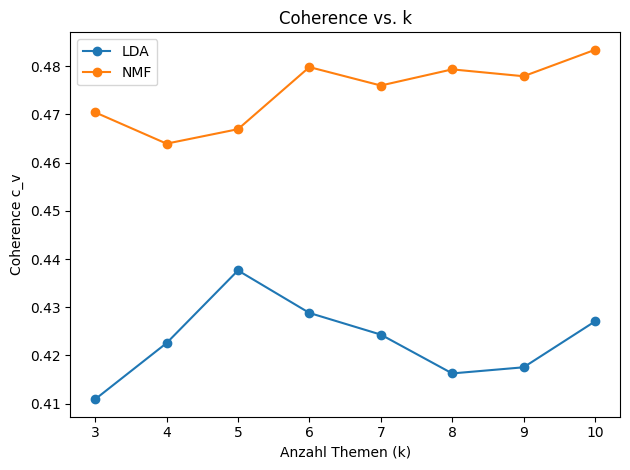

In [18]:
from src.topic_models import grid_coherence_lda, grid_coherence_nmf
import matplotlib.pyplot as plt

tokenized = [s.split() for s in df["clean_review"].tolist()]
k_list = list(range(3, 11))  # bei Bedarf anpassen

coh_lda = grid_coherence_lda(df["clean_review"].tolist(), tokenized, k_list)
coh_nmf = grid_coherence_nmf(df["clean_review"].tolist(), tokenized, k_list)

best_k_lda = max(coh_lda, key=coh_lda.get)
best_k_nmf = max(coh_nmf, key=coh_nmf.get)
print("Bestes k – LDA:", best_k_lda, "c_v:", round(coh_lda[best_k_lda], 3))
print("Bestes k – NMF:", best_k_nmf, "c_v:", round(coh_nmf[best_k_nmf], 3))

plt.figure()
plt.plot(list(coh_lda.keys()), list(coh_lda.values()), marker="o", label="LDA")
plt.plot(list(coh_nmf.keys()), list(coh_nmf.values()), marker="o", label="NMF")
plt.xlabel("Anzahl Themen (k)"); plt.ylabel("Coherence c_v"); plt.title("Coherence vs. k")
plt.legend(); plt.tight_layout()
plt.savefig(str(REPORTS / "coherence_vs_k.pdf")); plt.show()


In [19]:
import pandas as pd
from src.topic_models import train_lda_bow, train_nmf_tfidf, top_words_per_topic

lda_best = train_lda_bow(X_bow, best_k_lda)
nmf_best = train_nmf_tfidf(X_tfidf, best_k_nmf)

lda_topics = top_words_per_topic(lda_best, cv.get_feature_names_out(), 12)
nmf_topics = top_words_per_topic(nmf_best, tv.get_feature_names_out(), 12)

pd.DataFrame(lda_topics).to_csv(REPORTS / "topics_lda.csv", index=False, header=False)
pd.DataFrame(nmf_topics).to_csv(REPORTS / "topics_nmf.csv", index=False, header=False)

print("Gespeichert:")
print(" -", REPORTS / "coherence_vs_k.pdf")
print(" -", REPORTS / "topics_lda.csv")
print(" -", REPORTS / "topics_nmf.csv")


Gespeichert:
 - C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\reports\coherence_vs_k.pdf
 - C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\reports\topics_lda.csv
 - C:\Users\FJU\Desktop\FJ\UNI\Data Analysis\Junius-Fiona_ProjektDataAnalysis_P1_repo_duckdb\Junius-Fiona_32111962_ProjektDataAnalysis_P1\reports\topics_nmf.csv


In [20]:
def label_topic(words):
    joined = " ".join(words)
    if any(w in joined for w in ["clean","dirty","smell","bathroom","housekeeping","sauber"]): return "Sauberkeit"
    if any(w in joined for w in ["staff","service","friendly","helpful","personal"]):         return "Personal/Service"
    if any(w in joined for w in ["location","walk","station","distance","lage"]):            return "Lage/Anbindung"
    if any(w in joined for w in ["price","value","expensive","cheap","preis"]):              return "Preis-Leistung"
    if any(w in joined for w in ["room","bed","noise","quiet","size","zimmer"]):             return "Zimmer/Komfort"
    return "Sonstiges"

labels_lda = [label_topic(t) for t in lda_topics]
labels_nmf = [label_topic(t) for t in nmf_topics]
print("LDA Labels:", list(enumerate(labels_lda, 1)))
print("NMF Labels:", list(enumerate(labels_nmf, 1)))


LDA Labels: [(1, 'Sauberkeit'), (2, 'Sonstiges'), (3, 'Sauberkeit'), (4, 'Personal/Service'), (5, 'Personal/Service')]
NMF Labels: [(1, 'Sonstiges'), (2, 'Sonstiges'), (3, 'Sauberkeit'), (4, 'Sauberkeit'), (5, 'Sauberkeit'), (6, 'Personal/Service'), (7, 'Personal/Service'), (8, 'Sauberkeit'), (9, 'Sauberkeit'), (10, 'Sonstiges')]
